In [107]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import io
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as plt
from pandas import Series, DataFrame
import json
from pandas.io.json import json_normalize
import sys
import scipy as sp

%pylab inline

if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2018")
    


Populating the interactive namespace from numpy and matplotlib
Must set env variable PUI2018


# Idea: Do Males Spend More Time Riding a CitiBike than Females Do on Average? Or They Spend Equal Amount of Time on Riding the CitiBike on Average? Or the Opposite?
# I will use a significance level  $\alpha=0.05$
# which means i want the probability of getting a statistically significant result greater than 95%

# Null Hypothesis: Men and Women Spend Equal Amount of Time on Riding the CitiBike on Average.

# Alternate Hypothesis: Men and Women Spend Different Amount of Time on Riding the CitiBike on Average. (this implies that I will probably do a two-tail test)

In [90]:

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [91]:
datestring = '201502'
getCitiBikeCSV(datestring)

file in place, you can continue


In [92]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df['date'] = pd.to_datetime(df['starttime'])
df.head()
df.drop(['starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)

In [93]:
df.head()

,tripduration,gender,date
0,801,2,2015-02-01 00:00:00
1,379,1,2015-02-01 00:00:00
2,2474,2,2015-02-01 00:01:00
3,818,2,2015-02-01 00:01:00
4,544,1,2015-02-01 00:01:00


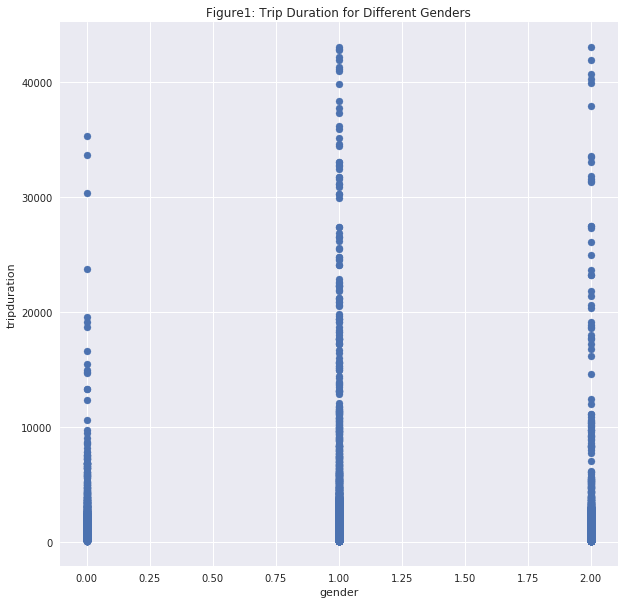

In [94]:
fig = pl.figure(figsize(10,10))
#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
y = df['tripduration']
x = df['gender']


pylab.ylabel('tripduration')
pylab.xlabel('gender')
pylab.title('Figure1: Trip Duration for Different Genders')
plt.scatter(x,y)
plt.show()


# Figure 1 
This is a scatter plot of trip duration against genders which 1 stands for male and 2 for female.

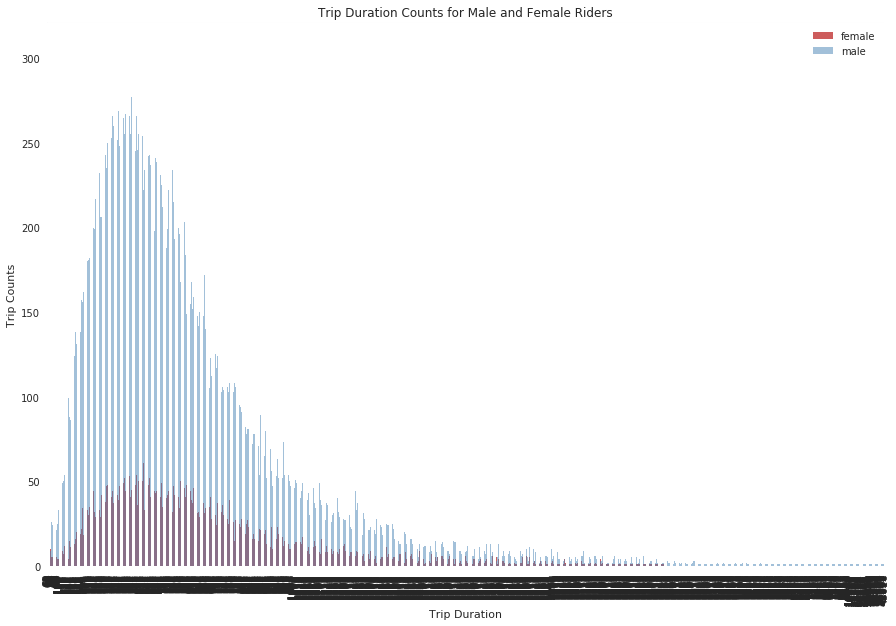

In [114]:
fig = plt.figure(figsize(15,10))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_w = 1
ax = ((df['tripduration'][df['gender'] == 2].groupby([df['tripduration']]).count()) / norm_w).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='female')

norm_m = 1
ax = ((df['tripduration'][df['gender'] == 1].groupby([df['tripduration']]).count()) / norm_m).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.5,
                                                                                              label='male')
ax.set_title ("Trip Duration Counts for Male and Female Riders")
ax.set_ylabel ("Trip Counts")
ax.set_xlabel ("Trip Duration")
plt.legend()

# Figure 2
This is a bar graph that plot to see the comparison between male and female riders' trip counts and trip duration. 

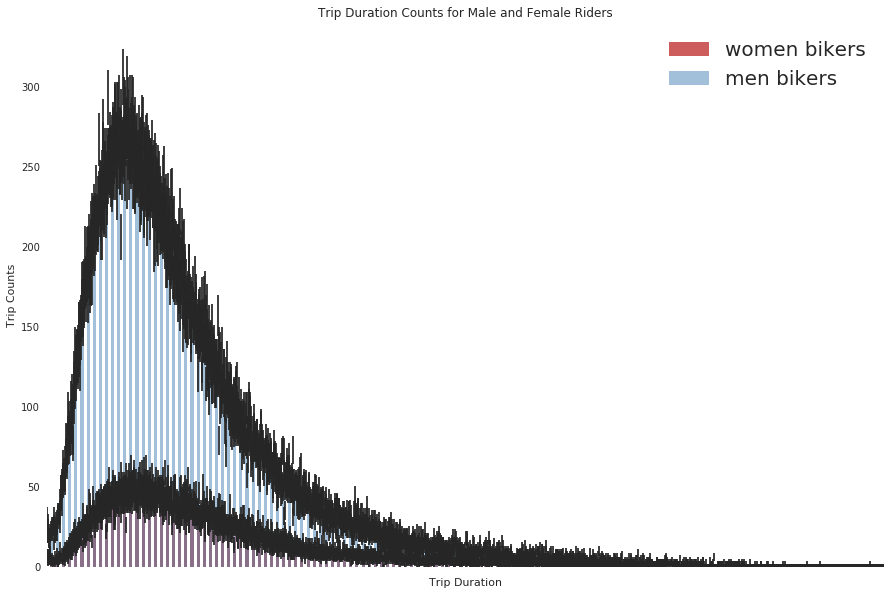

In [113]:
fig=plt.figure(figsize(15,10))

counts_w = df.date[df.gender == 2].groupby([df['tripduration']]).count()
norm_w = 1
error_w = np.sqrt(counts_w)
ax=((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women bikers')


counts_m = df.date[df.gender==1].groupby([df['tripduration']]).count()
norm_m = 1
error_m=np.sqrt(counts_m)
((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m) / norm_m, (error_m) / norm_m)], 
                           color='SteelBlue', label='men bikers')
ax.xaxis.set_ticklabels([''], fontsize=20)
ax.set_title ("Trip Duration Counts for Male and Female Riders")
ax.set_ylabel ("Trip Counts")
ax.set_xlabel ("Trip Duration")
plt.legend(['women bikers','men bikers'],fontsize=20)

# Figure 3
This is a bar graph that plot to see the comparison between male and female riders' trip counts and trip duration adjusted for statistical error. 

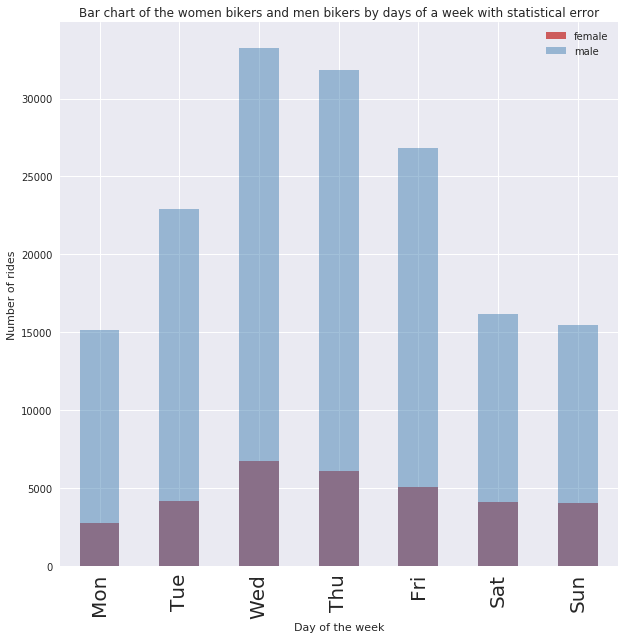

In [125]:

fig = pl.figure(figsize(10,10))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_w = 1
((df['date'][df['gender'] == 2].groupby([df['date'].dt.weekday]).count()) / norm_w).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='female')

norm_m = 1
ax = ((df['date'][df['gender'] == 1].groupby([df['date'].dt.weekday]).count()) / norm_m).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.5,
                                                                                              label='male')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_title("Bar chart of the women bikers and men bikers by days of a week with statistical error")
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day of the week")
pl.legend()

# Figure 4
This is a bar chart of the women bikers and men bikers by days of a week. The red legend represents female riders while the blue legend repersents male riders.

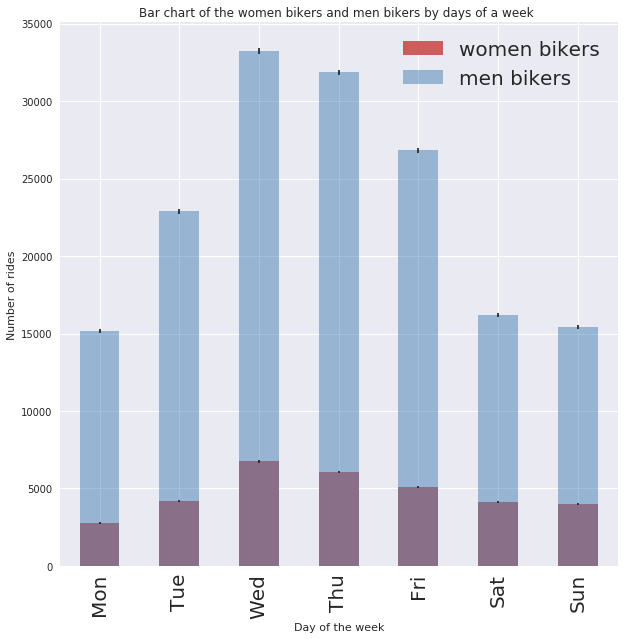

In [120]:
fig=pl.figure(figsize(10,10))

counts_w = df.date[df.gender == 2].groupby([df.date.dt.weekday]).count()
norm_w = 1
error_w = np.sqrt(counts_w)
ax=((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women bikers')


counts_m = df.date[df.gender==1].groupby([df.date.dt.weekday]).count()
norm_m = 1
error_m=np.sqrt(counts_m)
((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m) / norm_m, (error_m) / norm_m)], 
                           color='SteelBlue', label='men bikers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day of the week")
ax.set_title("Bar chart of the women bikers and men bikers by days of a week ")
pl.legend(['women bikers','men bikers'],fontsize=20)

# Figure 5
This is a bar chart of the women bikers and men bikers by days of a week adjusted for statistical errors. The red legend represents female riders while the blue legend repersents male riders.

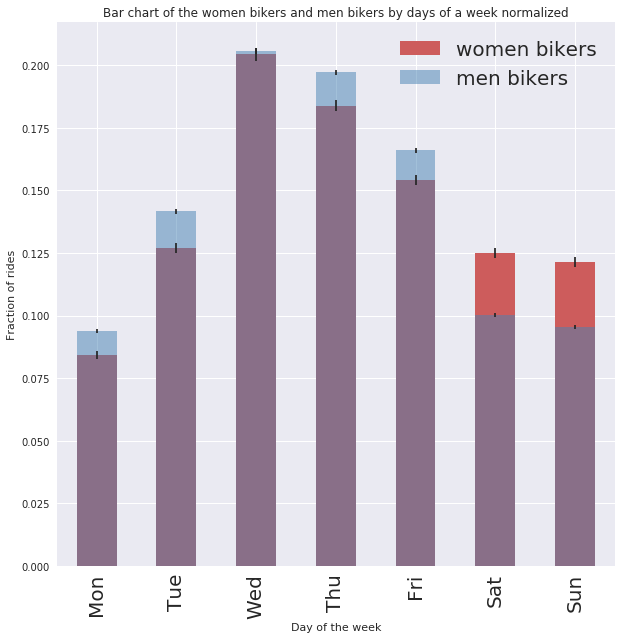

In [124]:
fig = pl.figure(figsize(10,10))

norm_w = counts_w.sum()
error_w = np.sqrt(counts_w)
((counts_w) / norm_w).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_w) / norm_w, (error_w) / norm_w)], 
                           label='women bikers')

norm_m = counts_m.sum()
ax = ((counts_m) / norm_m).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_m) / norm_m, (error_m) / norm_m)], 
                                color='SteelBlue', label='men bikers')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")
ax.set_title("Bar chart of the women bikers and men bikers by days of a week normalized")
pl.legend(['women bikers','men bikers'],fontsize=20)

# Figure 6
This is a bar chart of the women bikers and men bikers by days of a week normalized. The red legend represents female riders while the blue legend repersents male riders.